In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import joblib
#################################
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV

# Traitement des données

In [3]:
# Import des données
df_2023 = pd.read_csv("atp_matches_2023.csv", sep = ',', header = 0)
df_2023 = df_2023[::-1]
df_2023.reset_index(drop=True, inplace=True)
df_2022 = pd.read_csv("atp_matches_2022.csv", sep = ',', header = 0)
df_2022 = df_2022[::-1]
df_2022.reset_index(drop=True, inplace=True)
df_2021 = pd.read_csv("atp_matches_2021.csv", sep = ',', header = 0)
df_2021 = df_2021[::-1]
df_2021.reset_index(drop=True, inplace=True)
df_2020 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2020 = df_2020[::-1]
df_2020.reset_index(drop=True, inplace=True)
df_2019 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2019 = df_2019[::-1]
df_2019.reset_index(drop=True, inplace=True)
df_2018 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2018 = df_2018[::-1]
df_2018.reset_index(drop=True, inplace=True)
df_2017 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2017 = df_2017[::-1]
df_2017.reset_index(drop=True, inplace=True)
df_2016 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2016 = df_2016[::-1]
df_2016.reset_index(drop=True, inplace=True)
df_2015 = pd.read_csv("atp_matches_2020.csv", sep = ',', header = 0)
df_2015 = df_2015[::-1]
df_2015.reset_index(drop=True, inplace=True)
data = pd.concat([df_2023, df_2022, df_2021, df_2020, df_2019, df_2018, df_2017, df_2016, df_2015], ignore_index=True)

# Retirer des matchs 

In [4]:
# Retirer les abandons, DavidCUP et garder uniquement sur DUR en 3 sets max
data = data[~data['score'].str.contains('RET')]
data = data[~data['tourney_name'].str.contains('Davis Cup')]
data = data[data['best_of'] == 3]
data = data[data['surface'] == 'Hard']

# Remplacer les gauchers et droitiers
data["winner_hand"] = data["winner_hand"].replace({"R": 0, "L": 1, "U": np.nan})
data["loser_hand"] = data["loser_hand"].replace({"R": 0, "L": 1, "U": np.nan})

# Ajouter le nombre du set pendant le match
data['nb_set'] = data['score'].str.count('-')

# Avoir au moins 10 matchs sur 8 ans
all_names = pd.concat([data['winner_name'], data['loser_name']])
name_counts = all_names.value_counts()
filtered_names = name_counts[name_counts >= 1].index.tolist()
data = data[data['winner_name'].isin(filtered_names) | data['loser_name'].isin(filtered_names)]
data.shape

(7598, 50)

# Rennomage et selection

In [5]:
# Selection des variables
data = data[['winner_id', 'winner_name', 'winner_hand', 'winner_ht',
             'loser_id', 'loser_name', 'loser_hand', 'loser_ht',
             'w_ace', 'w_df', 'w_svpt', 'w_1stIn', 'w_1stWon',
             'w_2ndWon', 'w_SvGms', 'w_bpSaved', 'w_bpFaced',
             'l_ace', 'l_df', 'l_svpt', 'l_1stIn', 'l_1stWon',
             'l_2ndWon', 'l_SvGms', 'l_bpSaved', 'l_bpFaced',
             'nb_set']]
# Rename
data.rename(columns={
    'winner_id': 'w_id',
    'winner_name': 'w_name',
    'winner_hand': 'w_hand',
    'winner_ht': 'w_ht',
    'loser_id': 'l_id',
    'loser_name': 'l_name',
    'loser_hand': 'l_hand',
    'loser_ht': 'l_ht',
    'w_ace': 'w_ace',
    'w_df': 'w_df',
    'w_svpt': 'w_svpt',
    'w_1stIn': 'w_1stIn',
    'w_1stWon': 'w_1stWon',
    'w_2ndWon': 'w_2ndWon',
    'w_SvGms': 'w_SvGms',
    'w_bpSaved': 'w_bpSaved',
    'w_bpFaced': 'w_bpFaced',
    'l_ace': 'l_ace',
    'l_df': 'l_df',
    'l_svpt': 'l_svpt',
    'l_1stIn': 'l_1stIn',
    'l_1stWon': 'l_1stWon',
    'l_2ndWon': 'l_2ndWon',
    'l_SvGms': 'l_SvGms',
    'l_bpSaved': 'l_bpSaved',
    'l_bpFaced': 'l_bpFaced',
    'nb_set': 'nb_set'
}, inplace=True)
data.reset_index(drop=True, inplace=True)
data = data.dropna()

In [6]:
# Pourcentage de première balle
data['w_prcent1st'] = data['w_1stIn'] / data['w_svpt']
data['l_prcent1st'] = data['l_1stIn'] / data['l_svpt']
# Pourcentage de première balle win
data['w_prcent1stwin'] = data['w_1stWon'] / data['w_1stIn']
data['l_prcent1stwin'] = data['l_1stWon'] / data['l_1stIn']
# Nb deuxieme balle
data['w_2ndball'] = data['w_svpt'] - data['w_1stIn']
data['l_2ndball'] = data['l_svpt'] - data['l_1stIn']
# Pourcentage de deuxieme balle win
data['w_prcent2ndwin'] = data['w_2ndWon'] / data['w_2ndball']
data['l_prcent2ndwin'] = data['l_2ndWon'] / data['l_2ndball']
# Pourcentage de jeux de services gagnés
data['w_prcentgameserve'] =  (data['w_SvGms'] - (data['w_bpFaced']- data['w_bpSaved'])) / data['w_SvGms']
data['l_prcentgameserve'] =  (data['l_SvGms'] - (data['l_bpFaced']- data['l_bpSaved'])) / data['l_SvGms']
# Pourcentage de jeux de retours gagnés
data['w_prcentgamesreturn'] = 1 - data['l_prcentgameserve']
data['l_prcentgamesreturn'] = 1 - data['w_prcentgameserve']
# Pourcentage de pts gagnés sur 1er balle au retour
data['w_prcent1stwinreturn'] = 1 - data['l_prcent1stwin']
data['l_prcent1stwinreturn'] = 1 - data['w_prcent1stwin']
# Pourcentage de pts gagnés sur 2eme balle au retour
data['w_prcent2ndwinreturn'] = 1 - data['l_prcent2ndwin']
data['l_prcent2ndwinreturn'] = 1 - data['w_prcent2ndwin']
# Pourcentage de balle de break convertis
data['w_breakwin'] = np.where(data['l_bpFaced'] == 0, 0, (data['l_bpFaced'] - data['l_bpSaved']) / data['l_bpFaced'])
data['l_breakwin'] = np.where(data['w_bpFaced'] == 0, 0, (data['w_bpFaced'] - data['w_bpSaved']) / data['w_bpFaced'])
# Définissez une fonction pour renommer les colonnes
def rename_columns(column_name):
    if column_name.startswith("w_"):
        return "Player1_" + column_name[2:]
    elif column_name.startswith("l_"):
        return "Player2_" + column_name[2:]
    else:
        return column_name

# Utilisez la méthode "rename" pour renommer les colonnes
data = data.rename(columns=rename_columns)

# Creation du dataset final

In [7]:
joueurs = []

# Itérez à travers chaque ligne de df_model
for index, row in data.iterrows():
    joueur1 = {
        'Player1_id' : row['Player1_id'],
        'Player1_name': row['Player1_name'],
        'Player1_hand': row['Player1_hand'],
        'Player1_ht': row['Player1_ht'],
        'Player1_ace': row['Player1_ace'],
        'Player1_df': row['Player1_df'],
        'Player1_svpt': row['Player1_svpt'],
        'Player1_1stIn': row['Player1_1stIn'],
        'Player1_1stWon': row['Player1_1stWon'],
        'Player1_2ndWon': row['Player1_2ndWon'],
        'Player1_SvGms' : row['Player1_SvGms'],
        'Player1_bpSaved' : row['Player1_bpSaved'],
        'Player1_bpFaced': row['Player1_bpFaced'],
        'Player1_prcent1st': row['Player1_prcent1st'],
        'Player1_prcent1stwin': row['Player1_prcent1stwin'],
        'Player1_2ndball': row['Player1_2ndball'],
        'Player1_prcent2ndwin': row['Player1_prcent2ndwin'],
        'Player1_prcentgameserve': row['Player1_prcentgameserve'],
        'Player1_prcentgamesreturn': row['Player1_prcentgamesreturn'],
        'Player1_prcent1stwinreturn': row['Player1_prcent1stwinreturn'],
        'Player1_prcent2ndwinreturn': row['Player1_prcent2ndwinreturn'],
        'Player1_breakwin' : row['Player1_breakwin'],
        'Player2_id' : row['Player2_id'],
        'Player2_name': row['Player2_name'],
        'Player2_hand': row['Player2_hand'],
        'Player2_ht': row['Player2_ht'],
        'Player2_ace': row['Player2_ace'],
        'Player2_df': row['Player2_df'],
        'Player2_svpt': row['Player2_svpt'],
        'Player2_1stIn': row['Player2_1stIn'],
        'Player2_1stWon': row['Player2_1stWon'],
        'Player2_2ndWon': row['Player2_2ndWon'],
        'Player2_SvGms' : row['Player2_SvGms'],
        'Player2_bpSaved' : row['Player2_bpSaved'],
        'Player2_bpFaced': row['Player2_bpFaced'],
        'Player2_prcent1st': row['Player2_prcent1st'],
        'Player2_prcent1stwin': row['Player2_prcent1stwin'],
        'Player2_2ndball': row['Player2_2ndball'],
        'Player2_prcent2ndwin': row['Player2_prcent2ndwin'],
        'Player2_prcentgameserve': row['Player2_prcentgameserve'],
        'Player2_prcentgamesreturn': row['Player2_prcentgamesreturn'],
        'Player2_prcent1stwinreturn': row['Player2_prcent1stwinreturn'],
        'Player2_prcent2ndwinreturn': row['Player2_prcent2ndwinreturn'],
        'Player2_breakwin' : row['Player2_breakwin']
    }

    joueur2 = {
        'Player1_id' : row['Player2_id'],
        'Player1_name': row['Player2_name'],
        'Player1_hand': row['Player2_hand'],
        'Player1_ht': row['Player2_ht'],
        'Player1_ace': row['Player2_ace'],
        'Player1_df': row['Player2_df'],
        'Player1_svpt': row['Player2_svpt'],
        'Player1_1stIn': row['Player2_1stIn'],
        'Player1_1stWon': row['Player2_1stWon'],
        'Player1_2ndWon': row['Player2_2ndWon'],
        'Player1_SvGms' : row['Player2_SvGms'],
        'Player1_bpSaved' : row['Player2_bpSaved'],
        'Player1_bpFaced': row['Player2_bpFaced'],
        'Player1_prcent1st': row['Player2_prcent1st'],
        'Player1_prcent1stwin': row['Player2_prcent1stwin'],
        'Player1_2ndball': row['Player2_2ndball'],
        'Player1_prcent2ndwin': row['Player2_prcent2ndwin'],
        'Player1_prcentgameserve': row['Player2_prcentgameserve'],
        'Player1_prcentgamesreturn': row['Player2_prcentgamesreturn'],
        'Player1_prcent1stwinreturn': row['Player2_prcent1stwinreturn'],
        'Player1_prcent2ndwinreturn': row['Player2_prcent2ndwinreturn'],
        'Player1_breakwin' : row['Player2_breakwin'],
        'Player2_id' : row['Player1_id'],
        'Player2_name': row['Player1_name'],
        'Player2_hand': row['Player1_hand'],
        'Player2_ht': row['Player1_ht'],
        'Player2_ace': row['Player1_ace'],
        'Player2_df': row['Player1_df'],
        'Player2_svpt': row['Player1_svpt'],
        'Player2_1stIn': row['Player1_1stIn'],
        'Player2_1stWon': row['Player1_1stWon'],
        'Player2_2ndWon': row['Player1_2ndWon'],
        'Player2_SvGms' : row['Player1_SvGms'],
        'Player2_bpSaved' : row['Player1_bpSaved'],
        'Player2_bpFaced': row['Player1_bpFaced'],
        'Player2_prcent1st': row['Player1_prcent1st'],
        'Player2_prcent1stwin': row['Player1_prcent1stwin'],
        'Player2_2ndball': row['Player1_2ndball'],
        'Player2_prcent2ndwin': row['Player1_prcent2ndwin'],
        'Player2_prcentgameserve': row['Player1_prcentgameserve'],
        'Player2_prcentgamesreturn': row['Player1_prcentgamesreturn'],
        'Player2_prcent1stwinreturn': row['Player1_prcent1stwinreturn'],
        'Player2_prcent2ndwinreturn': row['Player1_prcent2ndwinreturn'],
        'Player2_breakwin' : row['Player1_breakwin']
    }

    joueurs.append(joueur1)
    joueurs.append(joueur2)

# Créez un DataFrame à partir de la liste de joueurs
df_joueurs = pd.DataFrame(joueurs)
df_streamlit = df_joueurs
colonnes_a_garder = [
    'Player1_hand', 'Player1_ht', 'Player1_ace', 'Player1_df', 'Player1_prcent1st',
    'Player1_prcent1stwin', 'Player1_prcent2ndwin', 'Player1_prcentgameserve',
    'Player2_hand', 'Player2_ht', 'Player2_ace', 'Player2_df', 'Player2_prcentgamesreturn',
    'Player2_prcent1stwinreturn', 'Player2_prcent2ndwinreturn', 'Player2_breakwin'
]
df_joueurs = df_joueurs[colonnes_a_garder]

# Entrainement du modele

R² : 0.7477120144134557


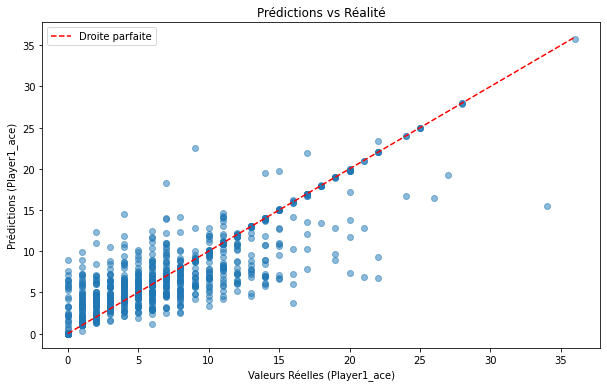

In [8]:
# Séparer les fonctionnalités (X) et la cible (y)
X = df_joueurs[[#'Player1_hand', 
                'Player1_ht','Player1_df',
                'Player1_prcent1st', 'Player1_prcent1stwin',
                'Player1_prcent2ndwin', 'Player1_prcentgameserve',
                #'Player2_hand', 
                'Player2_ht',
                'Player2_prcentgamesreturn', 'Player2_prcent1stwinreturn', 'Player2_prcent2ndwinreturn', 
                'Player2_breakwin'
                ]]
y = df_joueurs['Player1_ace']

# Diviser les données en ensembles d'entraînement et de test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
# Créer et entraîner le modèle de forêt aléatoire
model =RandomForestRegressor(
    # max_depth=8,
    # max_features='auto',
    # min_samples_leaf=1,
    # min_samples_split=2,
    # n_estimators=500#,
  #  random_state=42
)  # Vous pouvez ajuster les hyperparamètres selon vos besoins

model.fit(X_train, y_train)

# Faire des prédictions sur l'ensemble de test
y_pred = model.predict(X_test)

# Calculer le R²
r2 = r2_score(y_test, y_pred)
print(f"R² : {r2}")

# Créer une droite parfaite (y = x) pour la comparaison
x_line = np.linspace(min(y_test), max(y_test), 100)
y_line = x_line

# Tracer les prédictions par rapport aux valeurs réelles avec la droite parfaite
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot(x_line, y_line, color='red', linestyle='--', label='Droite parfaite')
plt.xlabel("Valeurs Réelles (Player1_ace)")
plt.ylabel("Prédictions (Player1_ace)")
plt.title("Prédictions vs Réalité")
plt.legend()
plt.show()


In [9]:
joblib.dump(model, 'modele_foret_aleatoire.pkl')

['modele_foret_aleatoire.pkl']

# Creation des futurs df pour streamlit

In [10]:
# Créez df_player1 avec les colonnes Player1_*
df_player1 = df_streamlit[['Player1_name',#'Player1_hand', 
                           'Player1_ht', 'Player1_ace', 'Player1_df', 'Player1_prcent1st',
    'Player1_prcent1stwin', 'Player1_prcent2ndwin', 'Player1_prcentgameserve']]

# Créez df_player2 avec les colonnes Player2_*
df_player2 = df_streamlit[[ 'Player2_name',#'Player2_hand', 
                           'Player2_ht',
                'Player2_prcentgamesreturn', 'Player2_prcent1stwinreturn', 'Player2_prcent2ndwinreturn', 'Player2_breakwin']]

# Maintenant, df_player1 et df_player2 contiennent les données des joueurs 1 et 2 respectivement.
print(df_player1.shape)
print(df_player2.shape)

(14570, 8)
(14570, 6)


# Generer les CSV

## Select Player

In [11]:
df_streamlit1 = pd.DataFrame({'Player1_name_unique': df_streamlit['Player1_name'].unique()})
df_streamlit1.to_csv("SelectionOFPlayer.csv")

## Select Player 1 & 2

In [12]:
# Initialiser un dictionnaire pour stocker les résultats
results = {"Player1_name": [],
           #"Player1_hand": [],
           "Player1_ht": [],
          "Player1_ace":[],
          "Player1_df":[],
          "Player1_prcent1st":[],
          "Player1_prcent1stwin":[],
          "Player1_prcent2ndwin": [],
          "Player1_prcentgameserve": []
          }

for player in tqdm(df_streamlit1['Player1_name_unique'], desc="Processing Players"):

  results["Player1_name"].append(player)
  matches = df_player1[(df_player1["Player1_name"]==player)]
  #recuperation des X derniers matchs de chaque joueur pour calculer des metrics
  last_10_matches = matches.head(20)
  last_1_matches = matches.head(1)
  # #hand
  # hand = last_1_matches[last_1_matches["Player1_name"]==player]["Player1_hand"].sum()
  # results["Player1_hand"].append(hand)
  # height
  height = last_1_matches[last_1_matches["Player1_name"]==player]["Player1_ht"].sum()
  results["Player1_ht"].append(height)
  #ace
  Player1_ace = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_ace"].sum()
  Player1_ace = Player1_ace / 20
  results["Player1_ace"].append(Player1_ace)
  # df
  Player1_df = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_df"].sum()
  Player1_df = Player1_df / 20
  results["Player1_df"].append(Player1_df)
  # Player1_prcent1st
  Player1_prcent1st = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_prcent1st"].sum()
  Player1_prcent1st = Player1_prcent1st / 20
  results["Player1_prcent1st"].append(Player1_prcent1st)
  # Player1_prcent1stwin
  Player1_prcent1stwin = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_prcent1stwin"].sum()
  Player1_prcent1stwin = Player1_prcent1stwin / 20
  results["Player1_prcent1stwin"].append(Player1_prcent1stwin)
    # Player1_prcent2ndwin
  Player1_prcent2ndwin = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_prcent2ndwin"].sum()
  Player1_prcent2ndwin = Player1_prcent2ndwin / 20
  results["Player1_prcent2ndwin"].append(Player1_prcent2ndwin)
      # Player1_prcentgameserve
  Player1_prcentgameserve = last_10_matches[last_10_matches["Player1_name"]==player]["Player1_prcentgameserve"].sum()
  Player1_prcentgameserve = Player1_prcentgameserve / 20
  results["Player1_prcentgameserve"].append(Player1_prcentgameserve)

player_j1_df_df = pd.DataFrame(results)
player_j1_df_df.to_csv("Player1.csv")


Processing Players:  14%|█▍        | 45/317 [00:00<00:01, 137.44it/s]

Processing Players: 100%|██████████| 317/317 [00:02<00:00, 154.87it/s]


In [13]:
# Initialiser un dictionnaire pour stocker les résultats
results = {"Player2_name": [],
          # "Player2_hand": [],
           "Player2_ht": [],
          "Player2_prcentgamesreturn":[],
          "Player2_prcent1stwinreturn":[],
          "Player2_prcent2ndwinreturn":[],
          "Player2_breakwin":[]
          }

for player in tqdm(df_streamlit1['Player1_name_unique'], desc="Processing Players"):

  results["Player2_name"].append(player)
  matches = df_player2[(df_player2["Player2_name"]==player)]
  #recuperation des X derniers matchs de chaque joueur pour calculer des metrics
  last_10_matches = matches.head(10)
  last_1_matches = matches.head(1)
  # #hand
  # hand = last_1_matches[last_1_matches["Player2_name"]==player]["Player2_hand"].sum()
  # results["Player2_hand"].append(hand)
 # height
  height = last_1_matches[last_1_matches["Player2_name"]==player]["Player2_ht"].sum()
  results["Player2_ht"].append(height)
  #ace
  Player2_prcentgamesreturn = last_10_matches[last_10_matches["Player2_name"]==player]["Player2_prcentgamesreturn"].sum()
  Player2_prcentgamesreturn = Player2_prcentgamesreturn / 10
  results["Player2_prcentgamesreturn"].append(Player2_prcentgamesreturn)
  # df
  Player2_prcent1stwinreturn = last_10_matches[last_10_matches["Player2_name"]==player]["Player2_prcent1stwinreturn"].sum()
  Player2_prcent1stwinreturn = Player2_prcent1stwinreturn / 10
  results["Player2_prcent1stwinreturn"].append(Player2_prcent1stwinreturn)
  # Player1_prcent1st
  Player2_prcent2ndwinreturn = last_10_matches[last_10_matches["Player2_name"]==player]["Player2_prcent2ndwinreturn"].sum()
  Player2_prcent2ndwinreturn = Player2_prcent2ndwinreturn / 10
  results["Player2_prcent2ndwinreturn"].append(Player2_prcent2ndwinreturn)
  # Player2_breakwin
  Player2_breakwin = last_10_matches[last_10_matches["Player2_name"]==player]["Player2_breakwin"].sum()
  Player2_breakwin = Player2_breakwin / 10
  results["Player2_breakwin"].append(Player2_breakwin)


player_j2_df_df = pd.DataFrame(results)
player_j2_df_df.to_csv("Player2.csv")


Processing Players: 100%|██████████| 317/317 [00:01<00:00, 204.87it/s]


In [14]:
print(player_j1_df_df.shape)
print(player_j2_df_df.shape)

(317, 8)
(317, 6)
